In [1]:
from util import *
from data_loader import *
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

In [200]:

# 0aa17642
wavename = '0d904cd7.wav'

config = Config(sampling_rate=44100,
                audio_duration=1.5,
                n_mels=128,
                frame_weigth=100,
                frame_shift=20,
                batch_size=4,
                n_folds=5,
                features_dir="../features/logmel_w100_s20_m128",
                model_dir='../model/mobileNetv2_test2',
                # prediction_dir='../prediction/mobileNetv2_test1',
                arch='resnet50_mfcc',
                lr=0.01,
                pretrain=True,
                mixup=False,
                #  epochs=100)
                epochs=200,
                debug=False)

In [126]:
X = load_data(os.path.join(config.features_dir, 'train_curated.pkl'))

In [123]:
df_train = pd.read_csv(config.CSV_TRAIN_CURATED)
LABELS = config.labels
label_idx = {label: i for i, label in enumerate(LABELS)}
df_train.set_index("fname")
df_train["label_idx"] = df_train['labels'].apply(multilabel_to_onehot, args=(label_idx,))
df_train.set_index("fname")
df_train.head()

,fname,labels,label_idx
0,0006ae4e.wav,Bark,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,0019ef41.wav,Raindrop,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,001ec0ad.wav,Finger_snapping,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,0026c7cb.wav,Run,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,0026f116.wav,Finger_snapping,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [150]:

trainSet = FreesoundLogmel(config=config, frame=df_train, X=X,
                           transform=transforms.Compose([ToTensor()]),
                           mode="train")
# trainSet = Freesound_logmel_discontinuous(config=config, frame=train_set, order=True,
#                      transform=transforms.Compose([ToTensor()]),
#                      mode="train")
train_loader = DataLoader(trainSet, batch_size=config.batch_size, shuffle=True, num_workers=4)


In [186]:
def one_hot_to_label(one_hot):
    labels = []
    for y_i in range(one_hot.shape[0]):
        if one_hot[y_i] > 0:
            labels.append(list(label_idx.keys())[list(label_idx.values()).index(y_i)])
    return labels


AttributeError: 'FreesoundLogmel' object has no attribute 'next'

18
(128, 75) ['Church_bell']
57
(128, 75) ['Scissors']
57
(128, 75) ['Scissors']
52
(128, 75) ['Printer']


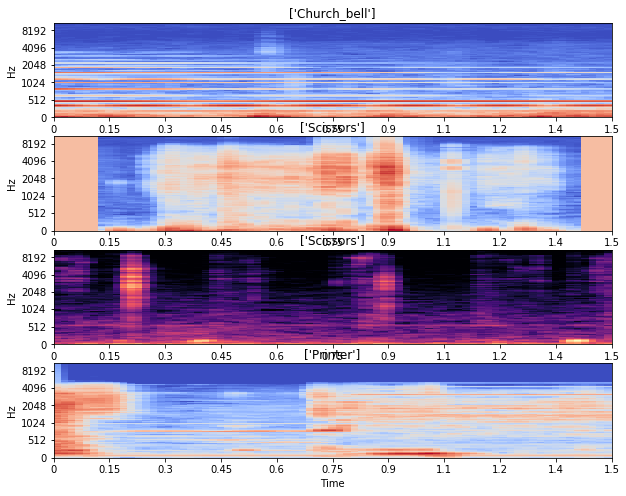

In [210]:
input, target = next(iter(train_loader))
plt.figure(figsize=(10,2*input.shape[0]))
for j in range(input.shape[0]):
    logmel_j = input[j,0,:].numpy()
    label_j = one_hot_to_label(target[j,::])
    print(logmel_j.shape,label_j)
    plt.subplot(input.shape[0], 1, j+1)
    librosa.display.specshow(logmel_j, x_axis='time', y_axis='mel', sr=config.sampling_rate, hop_length=config.hop_length)
    plt.title(label_j)
plt.show()

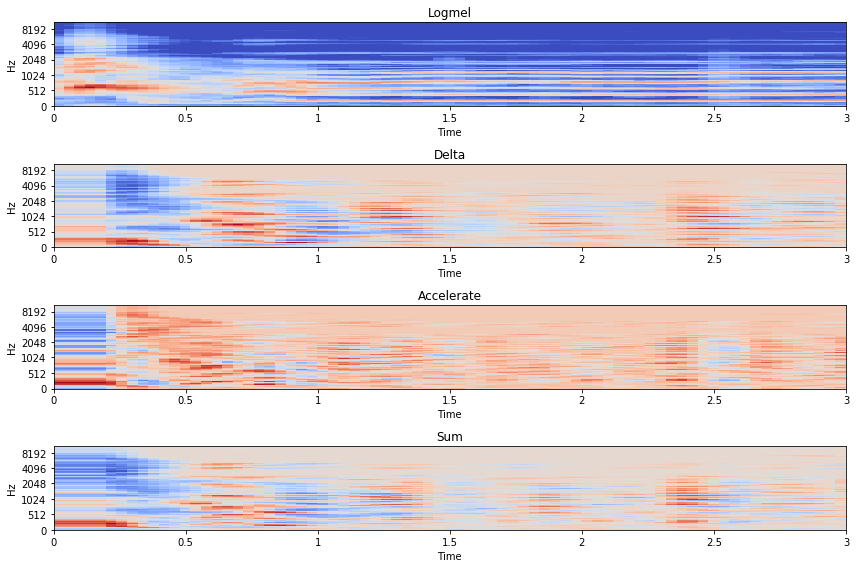

In [75]:

plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
librosa.display.specshow(x[0,::], x_axis='time', y_axis='mel', hop_length=config.hop_length)
plt.title('Logmel')
plt.subplot(4, 1, 2)
librosa.display.specshow(x[1,::], x_axis='time', y_axis='mel', hop_length=config.hop_length)
plt.title('Delta')
# plt.colorbar(format='%+02.0f dB')
plt.subplot(4, 1, 3)
librosa.display.specshow(x[2,::], x_axis='time', y_axis='mel', hop_length=config.hop_length)
plt.title('Accelerate')
plt.subplot(4, 1, 4)
librosa.display.specshow(x[1,::], x_axis='time', y_axis='mel', hop_length=config.hop_length)
plt.title('Sum')

plt.tight_layout()

In [20]:
model = mobilenet_v2(num_classes=config.num_classes)

In [21]:
checkpoint = '../model/mobileNetv2_test1/model_best.3.pth.tar'

print("=> loading checkpoint '{}'".format(checkpoint))
checkpoint = torch.load(checkpoint)

best_lwlrp = checkpoint['best_lwlrap']
# model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])
model = model.cuda()

print("=> loaded checkpoint, best_lwlrp: {:.3f}".format(best_lwlrp))

=> loading checkpoint '../model/mobileNetv2_test1/model_best.3.pth.tar'
=> loaded checkpoint, best_lwlrp: 0.646


In [26]:
xb = torch.from_numpy(x).type(torch.FloatTensor)
xb = torch.unsqueeze(xb, 0)
xb = xb.cuda()
xb.shape

torch.Size([1, 3, 128, 75])

In [57]:
model.features[1]

InvertedResidual(
  (conv): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [27]:
nn.Sequential(*list(model.children()))

Sequential(
  (0): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_

In [127]:
m_feature = nn.Sequential(*list(model.children())[:-1])
m_logit = nn.Sequential(*list(model.children())[-1:])

In [128]:
m = nn.Sequential(m_feature, m_logit)
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [132]:
m_logit = m_logit.cuda()

In [134]:
m_logit

Sequential(
  (0): Linear(in_features=2048, out_features=41, bias=True)
)

x_j:  torch.Size([1, 3, 128, 75])
None
preds: torch.Size([1, 80])
hook_a: torch.Size([1, 24, 32, 19])
acts: torch.Size([24, 32, 19])
grad:  torch.Size([24, 32, 19])
grad_chan:  torch.Size([24])


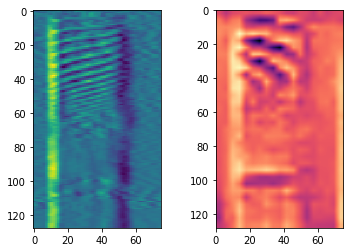

x_j:  torch.Size([1, 3, 128, 75])
None
preds: torch.Size([1, 80])
hook_a: torch.Size([1, 24, 32, 19])
acts: torch.Size([24, 32, 19])
grad:  torch.Size([24, 32, 19])
grad_chan:  torch.Size([24])


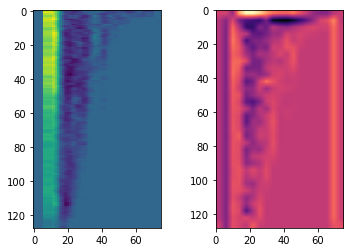

x_j:  torch.Size([1, 3, 128, 75])
None
preds: torch.Size([1, 80])
hook_a: torch.Size([1, 24, 32, 19])
acts: torch.Size([24, 32, 19])
grad:  torch.Size([24, 32, 19])
grad_chan:  torch.Size([24])


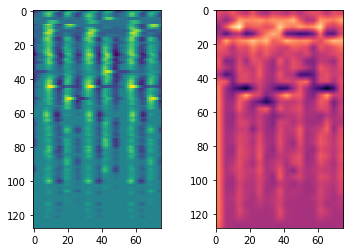

x_j:  torch.Size([1, 3, 128, 75])
None
preds: torch.Size([1, 80])
hook_a: torch.Size([1, 24, 32, 19])
acts: torch.Size([24, 32, 19])
grad:  torch.Size([24, 32, 19])
grad_chan:  torch.Size([24])


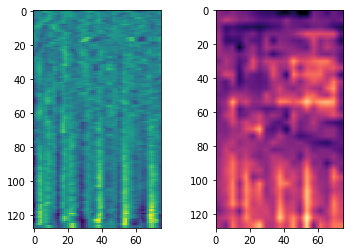

In [234]:
from fastai.callbacks.hooks import *

def visualize_by_cam(model, x, label_j):
    def hooked_backward(cat):
        with hook_output(model.features[2]) as hook_a: 
            print(hook_a.stored)
            with hook_output(model.features[2], grad=True) as hook_g:
                preds = model(x)
                print('preds:', preds.shape)
                preds[0,5].backward()
    #             print(hook_a.stored)
                print('hook_a:', hook_a.stored.shape)
        return hook_a,hook_g


    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
    #     axs[0].set_title(label)
    #     img.show(axs[0])
        axs[0].imshow(img)
    #     axs[1].set_title(f'CAM of {label}')
    #     img.show(axs[1])
    #     axs[1].imshow(img)
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[0],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()
        
    hook_a,hook_g = hooked_backward(cat=label_j)
    acts  = hook_a.stored[0].cpu()
    print('acts:', acts.shape)
    grad = hook_g.stored[0][0].cpu()
    print('grad: ', grad.shape)
    grad_chan = grad.mean(1).mean(1)
    print('grad_chan: ', grad_chan.shape)
    mult = (acts*grad_chan[...,None,None]).mean(0)
    show_heatmap(x[0,1,::], hm=mult, label=label_j)

    
input, target = next(iter(train_loader))
for j in range(input.shape[0]):
    x_j = input[j,::]
    x_j = torch.unsqueeze(x_j, 0).cuda()
    print('x_j: ', x_j.shape)
#     label_j = one_hot_to_label(target[j,::])
    label_j = target[j,::]
    visualize_by_cam(model, x_j, label_j)
    
# hook_a,hook_g = hooked_backward(cat=label_j)
# acts  = hook_a.stored[0].cpu()
# print('acts:', acts.shape)
# grad = hook_g.stored[0][0].cpu()
# print('grad: ', grad.shape)
# grad_chan = grad.mean(1).mean(1)
# print('grad_chan: ', grad_chan.shape)
# mult = (acts*grad_chan[...,None,None]).mean(0)

# show_heatmap(x[0,::], hm=mult, label=label_j)



In [228]:


input, target = next(iter(train_loader))
plt.figure(figsize=(10,2*input.shape[0]))
for j in range(input.shape[0]):
    logmel_j = input[j,0,:].numpy()
    label_j = one_hot_to_label(target[j,::])
    print(logmel_j.shape,label_j)
    plt.subplot(input.shape[0], 1, j+1)
    librosa.display.specshow(logmel_j, x_axis='time', y_axis='mel', sr=config.sampling_rate, hop_length=config.hop_length)
    plt.title(label_j)
    show_heatmap(img, hm, label)
    
    
hook_a,hook_g = hooked_backward(cat=)

SyntaxError: invalid syntax (<ipython-input-228-5b75288db70d>, line 15)

In [ ]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(model.layer1) as hook_a: 
        print(hook_a.stored)
        with hook_output(model.layer1, grad=True) as hook_g:
            preds = model(xb)
            print(preds.shape, 5 ,preds[0,5])
            print(preds)
            preds[0,5].backward()
#             print(hook_a.stored)
            print(hook_a.stored.shape)
    return hook_a,hook_g

In [111]:
hook_a,hook_g = hooked_backward(cat=4)

None
torch.Size([1, 80]) 5 tensor(-0.7338, device='cuda:0', grad_fn=<SelectBackward>)
tensor([[-0.0776, -1.4500, -1.0219,  0.2688,  1.0606, -0.7338, -1.9298, -0.2974,
         -0.1914, -0.3801, -0.1012,  0.1672, -1.0553, -0.1455, -0.0245, -0.1216,
          1.1987,  0.4832,  0.1979,  0.9752,  0.4171, -0.8592, -0.4278, -0.0373,
          0.3867,  0.0097,  1.6538, -0.0309,  0.2965, -0.7504,  0.1237, -0.5193,
          0.9502,  0.9848, -1.5532, -0.4529, -0.0435, -1.5410, -0.3333,  0.8536,
          0.9379, -0.6268,  1.5767, -0.9002,  0.1195, -1.0035,  0.0211, -0.7821,
         -1.2224,  0.9808,  0.8089,  0.1205,  0.5472,  0.0097, -0.5976, -0.4472,
          0.0923,  0.0271,  0.3809,  0.6459, -0.3392,  0.7365, -0.7974,  0.7417,
          0.9167,  2.0121, -1.1639, -1.6606,  0.7311, -0.2150, -0.2179, -0.3702,
          0.4594,  1.1004, -0.1057, -1.0721,  0.7578, -0.0994,  0.6450,  0.4902]],
       device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 64, 8, 5])


In [112]:
hook_a.stored.shape

torch.Size([1, 64, 8, 5])

In [113]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([64, 8, 5])

In [114]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([8, 5])

In [86]:
def show_heatmap(hm):
    print(hm.shape)
    _,ax = plt.subplots()
#     xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, 
              interpolation='bilinear', cmap='magma');
#     ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
#               interpolation='bilinear', cmap='magma');

In [115]:
def show_heatmap(img, hm, label):
    _,axs = plt.subplots(1, 2)
    axs[0].set_title(label)
#     img.show(axs[0])
    axs[0].imshow(img)
#     axs[1].set_title(f'CAM of {label}')
#     img.show(axs[1])
#     axs[1].imshow(img)
    axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[0],0),
                  interpolation='bilinear', cmap='magma');
    plt.show()

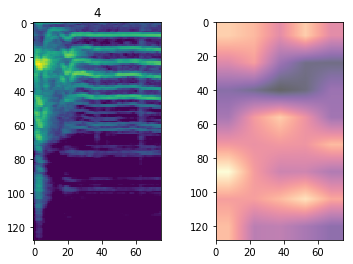

In [118]:
show_heatmap(x[0,::], avg_acts, 4)

Text(0.5, 1.0, 'Logmel spectrogram ')

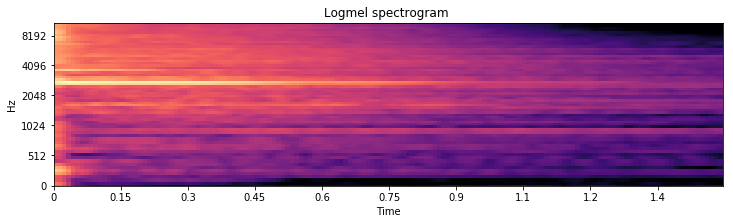

In [232]:
plt.figure(figsize=(12,3))
plt.subplot(1, 1, 1)
librosa.display.specshow(logmel[0,...,:150], x_axis='time', y_axis='mel', hop_length=config.hop_length)
plt.title('Logmel spectrogram ')

In [155]:
import PIL


acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(img=xb, hm=mult, label='123')

TypeError: show_heatmap() got an unexpected keyword argument 'img'

In [ ]:
def predict_one_model_with_logmel(checkpoint, frame, order):

    print("=> loading checkpoint '{}'".format(checkpoint))
    checkpoint = torch.load(checkpoint)

    best_prec1 = checkpoint['best_prec1']
    #  model = checkpoint['model']
    model = run_method_by_string(config.arch)(pretrained=config.pretrain)
    model.load_state_dict(checkpoint['state_dict'])
    model = model.cuda()

    print("=> loaded checkpoint, best_prec1: {:.2f}".format(best_prec1))

    input_frame_length = int(config.audio_duration * 1000 / config.frame_shift)
    stride = 20

    if config.cuda is True:
        model.cuda()

    model.eval()

    prediction = torch.zeros((1, 41)).cuda()

    file_names = []
    with torch.no_grad():

        for idx in tqdm(range(frame.shape[0])):
            filename = os.path.splitext(frame["fname"][idx])[0] + '.pkl'
            file_path = os.path.join(config.data_dir, filename)
            logmel = load_data(file_path)

            if logmel.shape[2] < input_frame_length:
                logmel = np.pad(logmel, ((0, 0), (0, 0), (0, input_frame_length - logmel.shape[2])), "constant")

            wins_data = []
            for j in range(0, logmel.shape[2] - input_frame_length + 1, stride):
                win_data = logmel[:, :, j: j + input_frame_length]
                wins_data.append(win_data)

            if len(wins_data) == 0:
                print(file_path)

            wins_data = np.array(wins_data)

            data = torch.from_numpy(wins_data).type(torch.FloatTensor)

            if config.cuda:
                data = data.cuda()

            output = model(data)
            output = torch.sum(output, dim=0, keepdim=True)

            prediction = torch.cat((prediction, output), dim=0)

            file_names.append(frame["fname"][idx])

    prediction = prediction[1:]
    return file_names, prediction

In [ ]:
train = pd.read_csv('../input/train.csv')

# train = train[:100] # for debug

LABELS = list(train.label.unique())

label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname")

train["label_idx"] = train.label.apply(lambda x: label_idx[x])

skf = StratifiedKFold(n_splits=config.n_folds)

predictions = np.zeros((1, 41))
file_names = []
for foldNum, (train_split, val_split) in enumerate(skf.split(train, train.label_idx)):
    val_set = train.iloc[val_split]
    val_set = val_set.reset_index(drop=True)
    print("Fold {0}, Val samples:{1}"
          .format(foldNum, len(val_set)))

    ckp = os.path.join(model_dir, 'model_best.%d.pth.tar' % foldNum)

    if input == 'wave':
        fn, pred = predict_one_model_with_wave(ckp, val_set)

    elif input == 'logmel':
        fn, pred = predict_one_model_with_logmel(ckp, val_set, order=order)

    file_names.extend(fn)

    predictions = np.concatenate((predictions, pred.cpu().numpy()))

predictions = predictions[1:]
save_to_csv(file_names, predictions, 'train_predictions.csv')

In [4]:
config = Config(sampling_rate=22050,
               audio_duration=1.5,
               batch_size=128,
               n_folds=5,
               data_dir="../logmel+delta_w80_s10_m64",
               model_dir='../model/interval_logmel_delta_resnet50',
               prediction_dir='../prediction/interval_logmel_delta_resnet50',
               arch='resnet50_mfcc',
               lr=0.01,
               pretrain=None,
               mixup=False,
               epochs=100)

checkpoint = '../model/interval_logmel_delta_resnet50/model_best.0.pth.tar'
print("=> loading checkpoint '{}'".format(checkpoint))
checkpoint = torch.load(checkpoint)

best_prec1 = checkpoint['best_prec1']
#  model = checkpoint['model']
model = run_method_by_string(config.arch)(pretrained=config.pretrain)
model.load_state_dict(checkpoint['state_dict'])
model = model.cuda()

print("=> loaded checkpoint, best_prec1: {:.2f}".format(best_prec1))


=> loading checkpoint '../model/interval_logmel_delta_resnet50/model_best.0.pth.tar'
=> loaded checkpoint, best_prec1: 81.38


In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F